In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score,train_test_split, KFold, GridSearchCV, ParameterGrid, \
RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor,BaggingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score, mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_convergence, plot_histogram, plot_objective
from IPython import display
import itertools as it
from sklearn.preprocessing import StandardScaler

#Libraries for visualizing trees
from sklearn.tree import export_graphviz, export_text
from six import StringIO
from IPython.display import Image  
import pydotplus
import time as time
import warnings

In [2]:
#Using the same datasets as in linear regression in STAT303-2, 
#so that we can compare the non-linear models with linear regression
trainf = pd.read_csv('./Datasets/Car_features_train.csv')
trainp = pd.read_csv('./Datasets/Car_prices_train.csv')
testf = pd.read_csv('./Datasets/Car_features_test.csv')
testp = pd.read_csv('./Datasets/Car_prices_test.csv')
train = pd.merge(trainf,trainp)
test = pd.merge(testf,testp)
train.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,18473,bmw,6 Series,2020,Semi-Auto,11,Diesel,145,53.3282,3.0,37980
1,15064,bmw,6 Series,2019,Semi-Auto,10813,Diesel,145,53.0430,3.0,33980
2,18268,bmw,6 Series,2020,Semi-Auto,6,Diesel,145,53.4379,3.0,36850
3,18480,bmw,6 Series,2017,Semi-Auto,18895,Diesel,145,51.5140,3.0,25998
4,18492,bmw,6 Series,2015,Automatic,62953,Diesel,160,51.4903,3.0,18990


In [3]:
X = train[['mileage','mpg','year','engineSize']]
Xtest = test[['mileage','mpg','year','engineSize']]
y = train['price']
ytest = test['price']

# Decision tree

In [4]:
model = DecisionTreeRegressor()
model.fit(X, y)

DecisionTreeRegressor()

In [5]:
model.get_depth()

29

In [6]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)
-np.mean(cross_val_score(DecisionTreeRegressor(), X, y, cv = cv, scoring= 'neg_root_mean_squared_error'))

7086.918648098317

In [10]:
grid = {'max_depth': Integer(2, 30)}


In [11]:
def monitor(optim_result):
    cv_values = pd.Series(optim_result['func_vals']).cummin()
    display.clear_output(wait = True)
    min_ind = pd.Series(optim_result['func_vals']).argmin()
    print(paras, "=", optim_result['x_iters'][min_ind], pd.Series(optim_result['func_vals']).min())
    sns.lineplot(cv_values)
    plt.show()

['max_depth'] = [10] 6409.682868979212


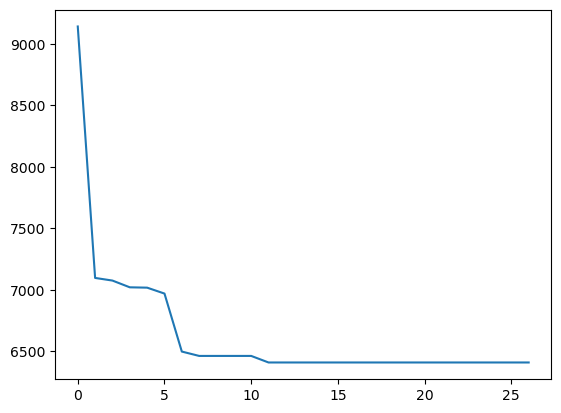

C:\Users\akl0407\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [10] before, using random point [26]
  warnings.warn(


KeyboardInterrupt: 

In [12]:
gcv = BayesSearchCV(model, search_spaces = grid, cv = cv, n_iter = 50, random_state = 10,
                         scoring = 'neg_root_mean_squared_error', n_jobs = -1)
paras = list(gcv.search_spaces.keys())
paras.sort()
gcv.fit(X, y, callback=monitor)

In [13]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)
-np.mean(cross_val_score(DecisionTreeRegressor(max_depth=10), X, y, cv = cv, scoring= 'neg_root_mean_squared_error'))

6482.198995888241

# Bag trees


In [14]:
model = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, oob_score=True)
model.fit(X, y)

BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100,
                 oob_score=True)

In [15]:
model.oob_score_

0.8980268815545959

In [16]:
mean_squared_error(model.oob_prediction_, y, squared=False)

5238.665741604997

In [17]:
model = BaggingRegressor(DecisionTreeRegressor(max_depth = 10), n_estimators=100, oob_score=True)
model.fit(X, y)
mean_squared_error(model.oob_prediction_, y, squared=False)

5320.9059559540465

In [21]:
model.estimators_[1]

DecisionTreeRegressor(max_depth=10, random_state=1077780385)

In [46]:
param_grid1 = {'max_samples': [0.25, 0.5, 0.75, 1.0],
             'max_features': [0.5, 0.75, 1.0],
             'bootstrap_features' : [True, False],
              'bootstrap': [True, False]}
param_grid2 = {'max_samples': [0.25, 0.5, 0.75, 1.0],
             'max_features': [1],
             'bootstrap_features' : [True],
              'bootstrap': [True, False]}
param_list1 = list(it.product(*[value for key, value in param_grid1.items()]))
param_list2 = list(it.product(*[value for key, value in param_grid2.items()]))
param_list = param_list1 + param_list2

In [47]:
oob_rmse = []
for pr in param_list:
    model = BaggingRegressor(DecisionTreeRegressor(), n_estimators=50, max_samples= pr[0],
                            max_features=pr[1], bootstrap_features=pr[2], oob_score=True, bootstrap=pr[3],
                            n_jobs = -1)
    model.fit(X, y)
    oob_rmse.append(mean_squared_error(model.oob_prediction_, y, squared=False))

ValueError: Out of bag estimation only available if bootstrap=True

In [32]:
np.min(oob_rmse)

5323.484479451253

In [34]:
param_list[np.argmin(oob_rmse)]

(0.75, 1.0, False)

['bootstrap', 'bootstrap_features', 'max_features', 'max_samples'] = [True, False, 4, 0.8940260768358883] 5533.292372435821


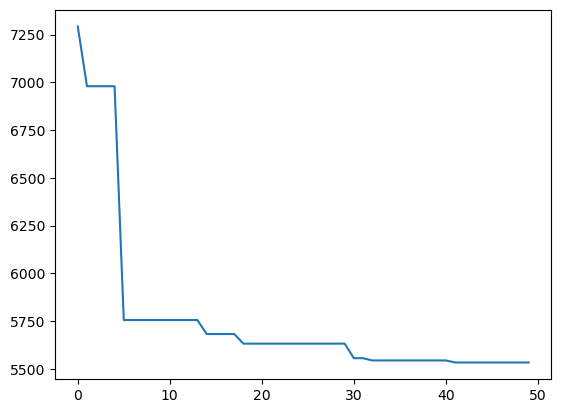

BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
              estimator=BaggingRegressor(estimator=DecisionTreeRegressor()),
              n_jobs=-1, random_state=10, scoring='neg_root_mean_squared_error',
              search_spaces={'bootstrap': [True, False],
                             'bootstrap_features': [True, False],
                             'max_features': Integer(low=1, high=4, prior='uniform', transform='normalize'),
                             'max_samples': Real(low=0.2, high=1.0, prior='uniform', transform='normalize')})

In [37]:
model = BaggingRegressor(DecisionTreeRegressor()) # No inputs defined inside the model
param_grid = {'max_samples': Real(0.2, 1.0),
             'max_features': Integer(1, 4),
             'bootstrap_features' : [True, False],
             'bootstrap': [True, False]}

kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)
gcv = BayesSearchCV(model, search_spaces = param_grid, cv = cv, n_iter = 50, random_state = 10,
                         scoring = 'neg_root_mean_squared_error', n_jobs = -1)
paras = list(gcv.search_spaces.keys())
paras.sort()
gcv.fit(X, y, callback=monitor)

<Axes: xlabel='bootstrap', ylabel='Sample Count'>

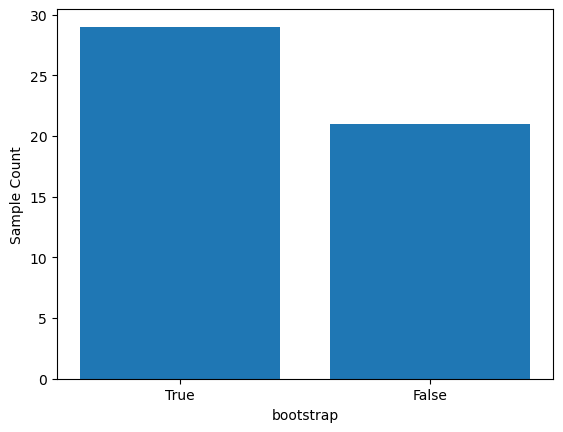

In [39]:
plot_histogram(gcv.optimizer_results_[0], 0)

<Axes: >

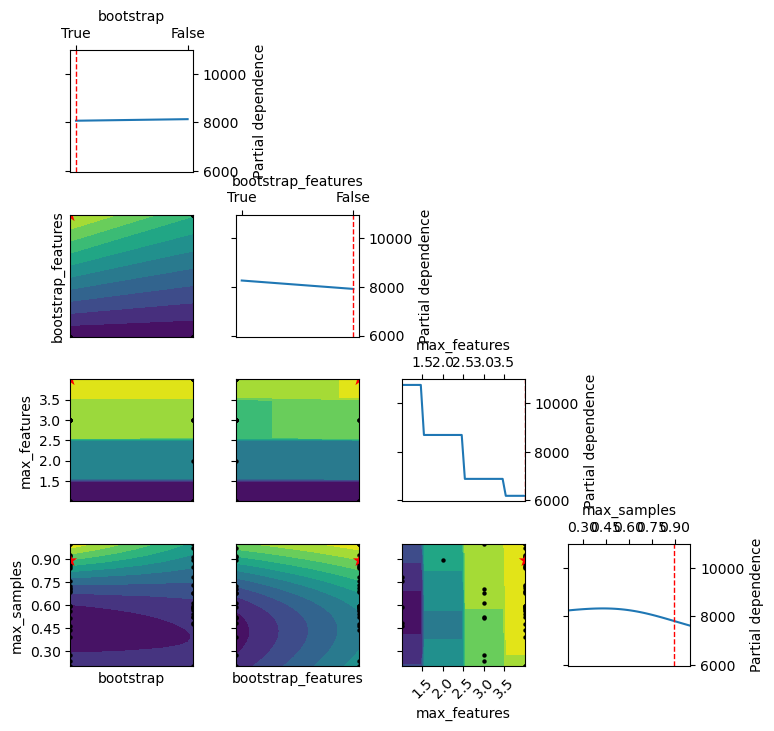

In [41]:
plot_objective(gcv.optimizer_results_[0])

# warm_start

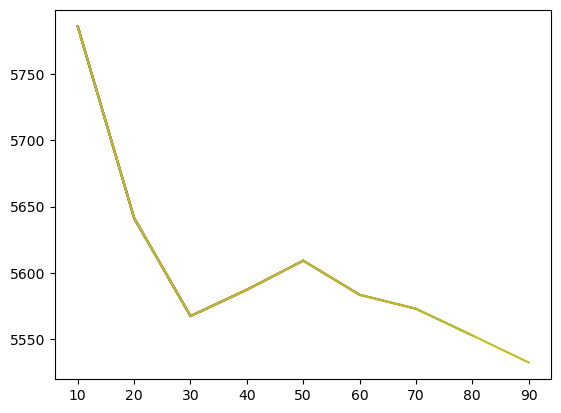

In [51]:
model = BaggingRegressor(DecisionTreeRegressor(), n_estimators=5, warm_start=True, n_jobs=-1)
model.fit(X, y)
rmse = []
for i in range(10, 100, 10):
    model.n_estimators = i
    model.fit(X, y)
    rmse.append(mean_squared_error(model.predict(Xtest), ytest, squared=False))
    sns.lineplot(x = range(10, i + 1, 10), y = rmse)

In [52]:
i

90

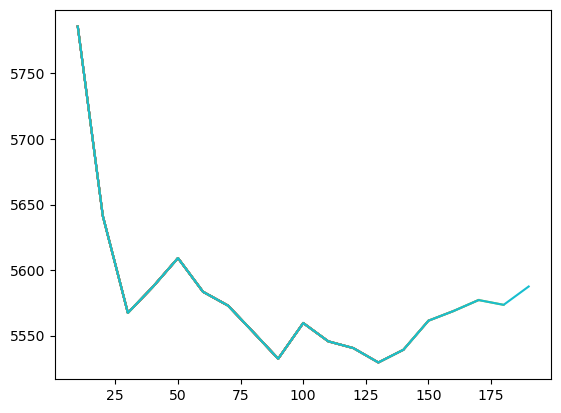

In [53]:
for i in range(100, 200, 10):
    model.n_estimators = i
    model.fit(X, y)
    rmse.append(mean_squared_error(model.predict(Xtest), ytest, squared=False))
    sns.lineplot(x = range(10, i + 1, 10), y = rmse)

In [ ]:
for i in range(200, 500, 10):
    model.n_estimators = i
    model.fit(X, y)
    rmse.append(mean_squared_error(model.predict(Xtest), ytest, squared=False))
    sns.lineplot(x = range(10, i + 1, 10), y = rmse)

In [54]:
model = KNeighborsRegressor()
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
-np.mean(cross_val_score(model, X_scaled, y, cv = cv, n_jobs = -1, scoring='neg_root_mean_squared_error'))

6766.935656359635

In [55]:
model = KNeighborsRegressor(n_neighbors=9)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
-np.mean(cross_val_score(model, X_scaled, y, cv = cv, n_jobs = -1, scoring='neg_root_mean_squared_error'))

6769.704640407092

In [57]:
model = BaggingRegressor(KNeighborsRegressor(), n_estimators=100)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
-np.mean(cross_val_score(model, X_scaled, y, cv = cv, n_jobs = -1, scoring='neg_root_mean_squared_error'))

6529.382480877771

In [58]:
model = BaggingRegressor(KNeighborsRegressor(n_neighbors=1), n_estimators=100)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
-np.mean(cross_val_score(model, X_scaled, y, cv = cv, n_jobs = -1, scoring='neg_root_mean_squared_error'))

6271.840616231707